## Topological Data Quality notebook

Here we review some examples from the article ``A topological Approach to Measuring Training Data Quality'' arXiv:2306.02411


In [1]:
import os
import numpy as np
import scipy.spatial.distance as dist
import matplotlib as mpl
import matplotlib.pyplot as plt
import gudhi

_tol = 1e-10

In [2]:
# Very important to compile IBloFunMatch.cc and obtain the correct executable path
EXECUTABLE_PATH = f"..\\x64\\Debug\\IBloFunMatchCPP.exe" # this is my particular path

In [3]:
! {EXECUTABLE_PATH + " -h"}


Given metric spaces S and X together with an inclusion f
from S to X, indicated by a set of indices, which is 
such that, for all a,b from X,  

         d(a,b) >= d_X(f(a), f(b)).

This induces a morphism of persistence modules

         PH_k(VR(S))-->PH_k(VR(X)), 

for all k>=0, and with fixed field Z/2Z.
Usage: ..\x64\Debug\IBloFunMatchCPP.exe [options] file_dist_S file_dist_X sample-indices, where:
 [file_dist_S] is the file storing the distance matrix from S
 [file_dist_X] is the file storing the distance matrix from X
 [sample-indices] is a file with the indices of elements from S in X.

Allowed options:
  -h [ --help ]                              produce help message
  -r [ --max-edge-length ] arg (=inf)        Maximal length of an edge for the Rips complex 
                                             construction.
  -d [ --cpx-dimension ] arg (=1)            Maximal dimension of the Rips complex we want to 
                                             compute.
  -i [ --edge-

### Define a function for calling C++ program compiled from IBloFunMatch.cc

In [4]:
def get_IBloFunMatch_output_range(data, y, S_list, yS_list, NUM_class, NUM_subset, attributes, types_list, output_dir):
    IBloFunMatch_output = [] # Store all output here 
    # Buffer files to write subsets and classes for communicating with C++ program 
    f_ind_sampl = output_dir + "\\indices_sample.out"
    f_dist_X = output_dir + "\\dist_X.out"
    f_dist_S = output_dir + "\\dist_S.out"
    for idx_class in range(NUM_class):
        for idx_subset in range(NUM_subset):
            output_data = {}
            # Subset and dataset points pertaining to class 
            subset = S_list[idx_subset]
            y_subset = yS_list[idx_subset]
            S = subset[y_subset==idx_class]
            X = data[y==idx_class]
            output_data["S"]=S
            output_data["X"]=X
            # Indices of points from S within X and save
            idS = [np.argmax(np.sum(abs(X - pt), axis=1) < _tol) for pt in S]
            output_data["idS"]=idS
            np.savetxt(f_ind_sampl, idS, fmt="%d", newline="\n")
            # Compute distance matrices and save
            Dist_X = dist.squareform(dist.pdist(X))
            Dist_S = dist.squareform(dist.pdist(S))
            np.savetxt(f_dist_X, Dist_X, fmt="%.14e", delimiter=" ", newline="\n")
            np.savetxt(f_dist_S, Dist_S, fmt="%.14e", delimiter=" ", newline="\n")
            # Call IBloFunMatch C++ program (only for dimension 1 PH)
            ! {EXECUTABLE_PATH + " " + f_dist_S + " " + f_dist_X + " " + f_ind_sampl + " -d 2"}
            # Save barcodes and representatives reading them from output files
            data_read = []
            for attribute_name, typename in zip(attributes, types_list):
                print(f"attribute:{attribute_name}, type:{typename}")
                print(output_dir + "\\" + attribute_name + ".out")
                with open(output_dir + "\\" + attribute_name + ".out") as file:
                    for line in file:
                        if(attribute_name == "induced_matching"):
                            data_read.append(int(line))
                        else:
                            data_line = line.split(" ")
                            if (typename=="int"): # lines end with additional space
                                data_line=data_line[:-1]
                            data_read.append(list(np.array(data_line).astype(typename)))
                        # end if else 
                    # end reading file lines 
                    if typename=="float":
                        output_data[attribute_name] = np.array(data_read)
                    else:
                        output_data[attribute_name] = data_read.copy()
                    # end if-else 
                # end opening file 
                data_read.clear()
            # end saving all attributes 
            # end for 
            IBloFunMatch_output.append(output_data)
        # subset range 
    # class range  
    return IBloFunMatch_output
# def get_IBloFunMatch_output_range

### Example 1

In [5]:
# Load data and labels
data = np.genfromtxt("data_first/dataset.txt")
y = np.genfromtxt("data_first/labels.txt")
# Load subsets S1, S2, S3 and get indices w.r.t. X
S1 = np.genfromtxt("data_first/subset1.txt")
S2 = np.genfromtxt("data_first/subset2.txt")
S3 = np.genfromtxt("data_first/subset3.txt")
# Load their labels 
yS1 = np.genfromtxt("data_first/labels_subset1.txt")
yS2 = np.genfromtxt("data_first/labels_subset2.txt")
yS3 = np.genfromtxt("data_first/labels_subset3.txt")

In [6]:
%%capture
# Compute the persistent homology and associated matrices for each class and subset
NUM_class = 2
NUM_subset = 3
# Get index array 
class_sub_idx = np.ones((NUM_class, NUM_subset)).astype("int")*(-1)
counter=0
# Range over Subsets and Classes
for idx_class in range(NUM_class):
    for idx_subset in range(NUM_subset):
        class_sub_idx[idx_class, idx_subset]=counter
        counter+=1
    # end for 
# end for 
# Organize Subset, Data and labels into lists
S_list = [S1, S2, S3]
yS_list = [yS1, yS2, yS3]
# Directory where output of C++ program will be read from
output_dir = "output"
# Initialize variables to range over 
attributes = ["X_barcode", "S_barcode", "X_reps", "S_reps", "S_reps_im", "pm_matrix", "induced_matching"]
types_list = ["float", "float", "int", "int", "int", "int", "int", "int"]
# Class, Subset index 
IBloFunMatch_output = get_IBloFunMatch_output_range(data, y, S_list, yS_list, NUM_class, NUM_subset, attributes, types_list, output_dir)

C:\Users\Alvaro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gudhi\persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


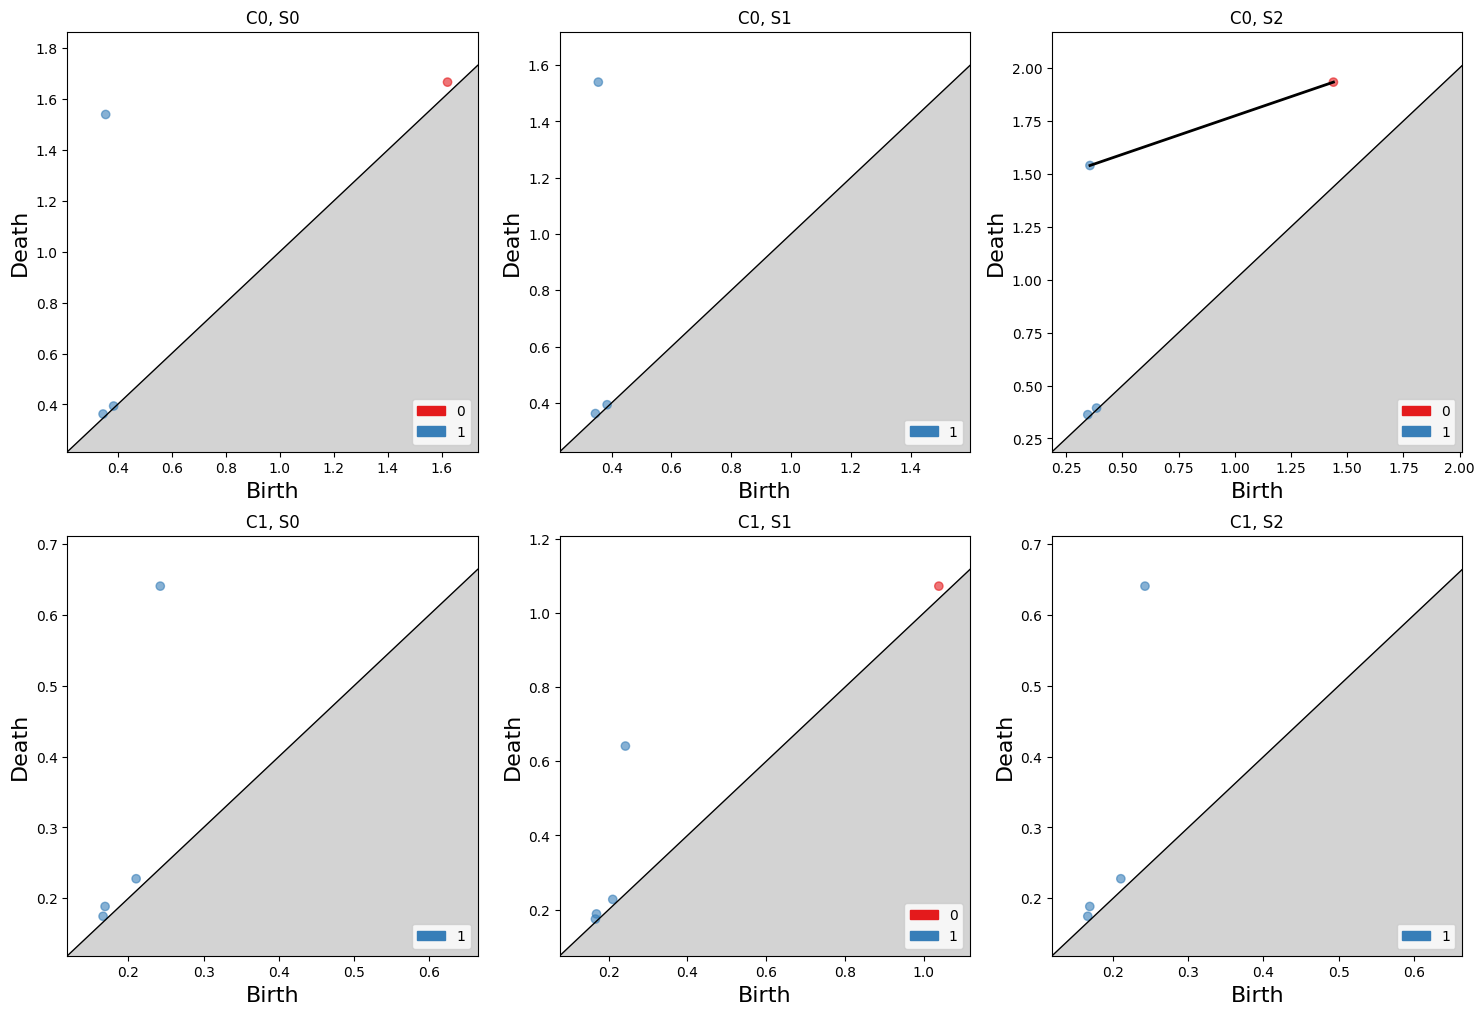

In [7]:
fig, ax = plt.subplots(nrows=NUM_class, ncols=NUM_subset, figsize=(6*NUM_subset, 6*NUM_class))
for idx_class in range(NUM_class):
    for idx_subset in range(NUM_subset):
        curr_output = IBloFunMatch_output[class_sub_idx[idx_class, idx_subset]]
        S_barcode = curr_output["S_barcode"]
        X_barcode = curr_output["X_barcode"]
        persistence = [(0, list(bar)) for bar in S_barcode] + [(1, list(bar)) for bar in X_barcode]
        gudhi.plot_persistence_diagram(persistence, axes=ax[idx_class, idx_subset])
        ax[idx_class, idx_subset].set_title(f"C{idx_class}, S{idx_subset}")
        induced_matching = curr_output["induced_matching"]
        for idx, match in enumerate(induced_matching):
            if match < 0:
                continue
            bar_or = S_barcode[idx]
            bar_to = X_barcode[match]
            ax[idx_class, idx_subset].plot([bar_or[0], bar_to[0]], [bar_or[1], bar_to[1]], linewidth=2, zorder=1, c="black")
        # end plotting matchings 
    # end subsets range 
# end index class range 
plt.savefig("first_example_matchings.png")

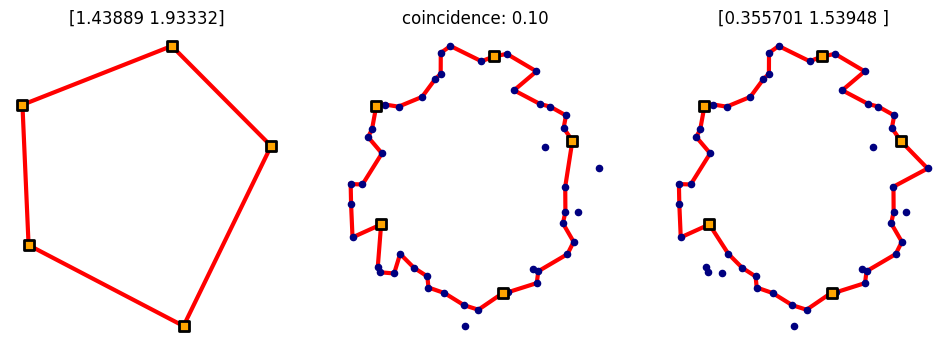

In [8]:
# Plot Point Clouds to visualize matchings
# Only relevant case is C0, S2
# Get relevant data
curr_output = IBloFunMatch_output[class_sub_idx[0][2]]
X = curr_output["X"]
S = curr_output["S"]
induced_matching = curr_output["induced_matching"]
X_reps = curr_output["X_reps"]
X_barcode = curr_output["X_barcode"]
S_reps = curr_output["S_reps"]
S_barcode = curr_output["S_barcode"]
S_reps_im = curr_output["S_reps_im"]
# Plot point clouds and matched representatives
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
# Titles of plots 
ax[0].set_title(f"{S_barcode[0]}")
ax[1].set_title(f"coincidence: {X_barcode[induced_matching[0]][1]-S_barcode[0][0]:.2f}")
ax[2].set_title(f"{X_barcode[induced_matching[0]]}")
#Plot cycle representatives of matching
Srep = S_reps[0].copy()
while len(Srep)>0:
    edge_points = X[[Srep.pop(), Srep.pop()]]
    ax[0].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
Srep_im = S_reps_im[0].copy()
while len(Srep_im)>0:
    edge_points = X[[Srep_im.pop(), Srep_im.pop()]]
    ax[1].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
Xrep = X_reps[induced_matching[0]].copy()
while len(Xrep)>0:
    edge_points = X[[Xrep.pop(), Xrep.pop()]]
    ax[2].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
# Scatter Points
for idx, ax_it in enumerate(ax):
    if idx>0:
        ax_it.scatter(X[:,0], X[:,1], zorder=2, color="navy", marker="o", s=20)
    ax_it.scatter(S[:,0], S[:,1], zorder=2.5, color="orange", edgecolors=["black"], linewidths=[2], marker="s", s=50)
    ax_it.set_xticks([])
    ax_it.set_yticks([])
    ax_it.axis("off")
# end plotting cycles 
plt.savefig("first_exp_matched_reps.png")

### Example 2

In [9]:
# Load data and labels
data = np.genfromtxt("data_second/dataset2.txt")
y = np.genfromtxt("data_second/dataset2_label.txt")
# Load subsets S1, S2, S3 and get indices w.r.t. X
S1 = np.genfromtxt("data_second/data2_subset1.txt")
S2 = np.genfromtxt("data_second/data2_subset2.txt")
# Load their labels 
yS1 = np.genfromtxt("data_second/data2_subset1_labels.txt")
yS2 = np.genfromtxt("data_second/data2_subset2_labels.txt")

In [10]:
%%capture
# Compute the persistent homology and associated matrices for each class and subset
NUM_class = 2
NUM_subset = 2
# Get index array 
class_sub_idx = np.ones((NUM_class, NUM_subset)).astype("int")*(-1)
counter=0
# Range over Subsets and Classes
for idx_class in range(NUM_class):
    for idx_subset in range(NUM_subset):
        class_sub_idx[idx_class, idx_subset]=counter
        counter+=1
    # end for 
# end for 
# Organize Subset, Data and labels into lists
S_list = [S1, S2]
yS_list = [yS1, yS2]
# Directory where output of C++ program will be read from
output_dir = "output"
# Initialize variables to range over 
attributes = ["X_barcode", "S_barcode", "X_reps", "S_reps", "S_reps_im", "pm_matrix", "induced_matching"]
types_list = ["float", "float", "int", "int", "int", "int", "int", "int"]
# Class, Subset index 
IBloFunMatch_output = get_IBloFunMatch_output_range(data, y, S_list, yS_list, NUM_class, NUM_subset, attributes, types_list, output_dir)

In [11]:
%%capture
fig, ax = plt.subplots(nrows=NUM_class, ncols=NUM_subset, figsize=(6*NUM_subset, 6*NUM_class))
for idx_class in range(NUM_class):
    for idx_subset in range(NUM_subset):
        curr_output = IBloFunMatch_output[class_sub_idx[idx_class, idx_subset]]
        S_barcode = curr_output["S_barcode"]
        X_barcode = curr_output["X_barcode"]
        persistence = [(0, list(bar)) for bar in S_barcode] + [(1, list(bar)) for bar in X_barcode]
        gudhi.plot_persistence_diagram(persistence, axes=ax[idx_class, idx_subset])
        ax[idx_class, idx_subset].set_title(f"C{idx_class}, S{idx_subset}")
        induced_matching = curr_output["induced_matching"]
        for idx, match in enumerate(induced_matching):
            if match < 0:
                continue
            bar_or = S_barcode[idx]
            bar_to = X_barcode[match]
            ax[idx_class, idx_subset].plot([bar_or[0], bar_to[0]], [bar_or[1], bar_to[1]], linewidth=2, zorder=1, c="black")
        # end plotting matchings 
    # end subsets range 
# end index class range 
plt.savefig("second_example_matchings.png")

In [12]:
%%capture
# Plot Point Clouds to visualize matchings
# Range over classes and subsets 
# Get relevant data
for idx_class in range(NUM_class):
    for idx_subset in range(NUM_subset):
        curr_output = IBloFunMatch_output[class_sub_idx[idx_class][idx_subset]]
        X = curr_output["X"]
        S = curr_output["S"]
        induced_matching = curr_output["induced_matching"]
        # Count number of nontrivial matchings 
        num_matchings = len([idx for idx in induced_matching if idx>-1])
        X_reps = curr_output["X_reps"]
        X_barcode = curr_output["X_barcode"]
        S_reps = curr_output["S_reps"]
        S_barcode = curr_output["S_barcode"]
        S_reps_im = curr_output["S_reps_im"]
        # Plot point clouds and matched representatives
        fig, ax = plt.subplots(nrows=num_matchings, ncols=3, figsize=(20, 4*num_matchings))
        #Plot cycle representatives of matching
        row_count = 0
        for idx_rep, idx_match in enumerate(induced_matching):
            if idx_match <0:
                continue
            # Set axis titles as intervals 
            ax[row_count, 0].set_title(f"{S_barcode[idx_rep]}")
            ax[row_count, 1].set_title(f"coincidence: {X_barcode[idx_match][1]-S_barcode[idx_rep][0]:.2f}")
            ax[row_count, 2].set_title(f"{X_barcode[idx_match]}")
            Srep = S_reps[idx_rep].copy()
            while len(Srep)>0:
                edge_points = X[[Srep.pop(), Srep.pop()]]
                ax[row_count, 0].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
            Srep_im = S_reps_im[idx_rep].copy()
            while len(Srep_im)>0:
                edge_points = X[[Srep_im.pop(), Srep_im.pop()]]
                ax[row_count, 1].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
            Xrep = X_reps[idx_match].copy()
            while len(Xrep)>0:
                edge_points = X[[Xrep.pop(), Xrep.pop()]]
                ax[row_count, 2].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
            # Scatter Points
            for idx, ax_it in enumerate(ax[row_count]):
                if idx>0:
                    ax_it.scatter(X[:,0], X[:,1], zorder=2, color="navy", marker="o", s=10)
                ax_it.scatter(S[:,0], S[:,1], zorder=2.5, color="orange", edgecolors=["black"], linewidths=[2], marker="s", s=30)
                ax_it.set_xticks([])
                ax_it.set_yticks([])
            # end plotting cycles
            row_count+=1
        # end going over different matchings 
        fig.tight_layout()
        plt.savefig(f"second_reps_{idx_class}_{idx_subset}.png")
    # subset range 
# class range